In [3]:
import numpy as np

# AMPD function
def ampd(sigInput, LSMlimit = 1):
	"""Find the peaks in the signal with the AMPD algorithm.
	
		Original implementation by Felix Scholkmann et al. in
		"An Efficient Algorithm for Automatic Peak Detection in 
		Noisy Periodic and Quasi-Periodic Signals", Algorithms 2012,
		 5, 588-603
		Parameters
		----------
		sigInput: ndarray
			The 1D signal given as input to the algorithm
		lsmLimit: float
			Wavelet transform limit as a ratio of full signal length.
			Valid values: 0-1, the LSM array will no longer be calculated after this point
			  which results in the inability to find peaks at a scale larger than this factor.
			  For example a value of .5 will be unable to find peaks that are of period 
			  1/2 * signal length, a default value of 1 will search all LSM sizes.
		Returns
		-------
		pks: ndarray
			The ordered array of peaks found in sigInput
	"""
		
	# Create preprocessing linear fit	
	sigTime = np.arange(0, len(sigInput))
	
	# Detrend
	dtrSignal = (sigInput - np.polyval(np.polyfit(sigTime, sigInput, 1), sigTime)).astype(float)
	
	N = len(dtrSignal)
	L = int(np.ceil(N*LSMlimit / 2.0)) - 1
	
	# Generate random matrix
	LSM = np.ones([L,N], dtype='uint8')
	
	# Local minima extraction
	for k in range(1, L):
		LSM[k - 1, np.where((dtrSignal[k:N - k - 1] > dtrSignal[0: N - 2 * k - 1]) & (dtrSignal[k:N - k - 1] > dtrSignal[2 * k: N - 1]))[0]+k] = 0
	
	pks = np.where(np.sum(LSM[0:np.argmin(np.sum(LSM, 1)), :], 0)==0)[0]
	return pks


# Fast AMPD		
def ampdFast(sigInput, order, LSMlimit = 1):
	"""A slightly faster version of AMPD which divides the signal in 'order' windows
		Parameters
		----------
		sigInput: ndarray
			The 1D signal given as input to the algorithm
		order: int
			The number of windows in which sigInput is divided
		Returns
		-------
		pks: ndarray
			The ordered array of peaks found in sigInput 
	"""

	# Check if order is valid (perfectly separable)
	if(len(sigInput)%order != 0):
		print("AMPD: Invalid order, decreasing order")
		while(len(sigInput)%order != 0):
			order -= 1
		print("AMPD: Using order " + str(order))

	N = int(len(sigInput) / order / 2)

	# Loop function calls
	for i in range(0, len(sigInput)-N, N):
		print("\t sector: " + str(i) + "|" + str((i+2*N-1)))
		pksTemp = ampd(sigInput[i:(i+2*N-1)], LSMlimit)
		if(i == 0):
			pks = pksTemp
		else:
			pks = np.concatenate((pks, pksTemp+i))
		
	# Keep only unique values
	pks = np.unique(pks)
	
	return pks

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

def f(x):
    return 1-np.abs(np.cos(3*x))+0.2*np.sin(63.1*x)

x = np.linspace(0.1,10.4,2000)
y = f(x)

In [22]:
res = ampd(y, 1)
#print(res)

#print(y[res])

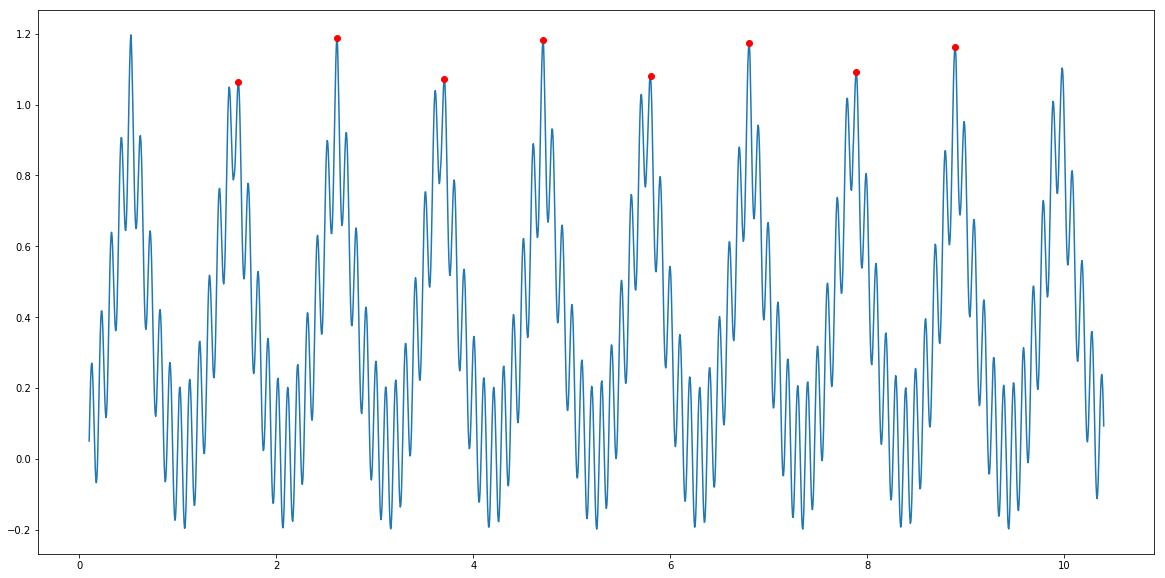

In [23]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(x,y)
ax.plot(x[res],y[res], 'ro')